In [461]:
import numpy as np
import matplotlib.pyplot as plt

from mytorch.nn.activation import ReLU, Sigmoid, Tanh, LinearActivation
from mytorch.nn.initialization import Xavier, He
from mytorch.nn.linear import Linear
from mytorch.nn.loss import CrossEntropyLoss, L2Loss
from mytorch.optim.optimizer import SGD, Adam
from models.mlp import MLP
import numpyNN

In [462]:
# based on dataset.py from IML HW 6 
def one_hot_encoding(y, num_classes=2):
    one_hot = np.eye(num_classes)[y.astype(int).flatten()]
    return one_hot

In [463]:
def train_and_test_mlp(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
    assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    y_train_encoded = one_hot_encoding(y_train)  
    y_test_encoded = one_hot_encoding(y_test)

    for epoch in range(num_epoch):
        # Shuffle training data and labels
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train_encoded[indices]

        batch_losses = []
        batch_accuracies = []

        # mini-batches
        for start_idx in range(0, x_train.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, x_train.shape[0])
            batch_x = x_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]

            y_pred_train = mlp.forward(batch_x)
            loss_train = opt_loss.forward(y_pred_train, batch_y)
            batch_losses.append(np.mean(loss_train))

            dLdZ = opt_loss.backward()  # Use correct call for backward computation
            mlp.backward(dLdZ)
            opt_optim.step()
            opt_optim.zero_grad()

            predicted_labels_train = np.argmax(y_pred_train, axis=1)
            true_labels_train = np.argmax(batch_y, axis=1)
            accuracy_train = np.sum(predicted_labels_train == true_labels_train) / len(batch_x)
            batch_accuracies.append(accuracy_train)

        # Compute mean loss and accuracy for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        # Testing (evaluate the model with the current state on the test set)
        mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
        y_pred_test = mlp_eval.forward(x_test)
        loss_test = opt_loss.forward(y_pred_test, y_test_encoded)
        test_loss.append(np.mean(loss_test))

        predicted_labels_test = np.argmax(y_pred_test, axis=1)
        true_labels_test = np.argmax(y_test_encoded, axis=1)
        accuracy_test = np.sum(predicted_labels_test == true_labels_test) / len(x_test)
        test_accuracy.append(accuracy_test)

        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}, Test Loss: {np.mean(loss_test)}, Test Accuracy: {accuracy_test}")

    logs = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    return logs

In [464]:
def plot_3d (x_train_augmented, y_train, feature, savefig=False, name= None):
    # Splitting x_train_augmented into separate features for easier handling
    feature_1 = x_train_augmented[:, 0]
    feature_2 = x_train_augmented[:, 1]
    feature_3 = x_train_augmented[:, 2]

    # Separating data points based on y_train values
    class_0_indices = (y_train.flatten() == 0)
    class_1_indices = (y_train.flatten() == 1)

    # Plotting Feature 1 vs Feature 3
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # (rows, columns, panel number)
    plt.scatter(feature_1[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_1[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    feature = '$' + feature + '$'
    title  = f'{feature} vs $x_i$'
    plt.title(rf'{title}')
    plt.xlabel(r'$x_i$')
    plt.ylabel(rf'{feature}')
    plt.legend()

    # Plotting Feature 2 vs Feature 3
    plt.subplot(1, 2, 2)
    plt.scatter(feature_2[class_0_indices], feature_3[class_0_indices], c='red', label='Class 0')
    plt.scatter(feature_2[class_1_indices], feature_3[class_1_indices], c='blue', label='Class 1')
    title  = f'{feature} vs $y_i$'
    plt.title(rf'{title}')    
    plt.xlabel(r'$y_i$')
    plt.ylabel(r'$x_{i}^2 + y_i^2$')
    plt.legend()

    plt.tight_layout()
    if savefig:
        name = name + '-embedding.png'
        plt.savefig(name)
        
    plt.show()

In [465]:
def make_nonlinearity(f1, f2, non_linear):
    f1, f2 = np.array(f1), np.array(f2)
    # Apply the non-linear function to f1 and f2
    non_linearity = non_linear(f1, f2)
    return non_linearity

In [466]:
def predict(X, model): # added this to work with my mlp
        y_pred = model.forward(X)
        return np.argmax(y_pred, axis=1)

In [489]:
def decision_boundary_plot(X, y, non_linearities, model,i=2,levels=10, savefig=False, name=None):
    feature_1 = X[:, 0]
    feature_2 = X[:, 1]
    feature_i = X[:, i]

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=50),
                        np.linspace(y_min, y_max, num=50))
    
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])

    X_grid_augmented = grid_points
    
    for non_linear in non_linearities:
        non_linearity = make_nonlinearity(xx.ravel(), yy.ravel(), non_linear)
        X_grid_augmented = np.c_[X_grid_augmented, non_linearity]
    
    Z_pred_grid = predict(X_grid_augmented, model=model)    
    Z_pred_reshaped = Z_pred_grid.reshape(xx.shape)
    
    
    fig = plt.figure(figsize=(20, 10))
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.contourf(xx, yy, Z_pred_reshaped, levels = levels, colors=['purple', 'yellow'], alpha=0.4, offset=.2)
    
    # Scatter plot of actual data points
    scatter = ax2.scatter(feature_1, feature_2, feature_i, c=y, cmap='viridis', edgecolors='k', s=50, alpha=0.6, marker='o')

    ax2.set_title('Predicted Decision Boundary', fontsize=18)
    ax2.set_xlabel('Feature 1', fontsize=15)
    ax2.set_ylabel('Feature 2', fontsize=15)
    ax2.set_zlabel('Feature 3', fontsize=15)
    # ax2.view_init(elev=30, azim=120, vertical_axis='y')
    if savefig:
        name = name + '-decision_boundary.png'
        plt.savefig(name, dpi=300)
    plt.show()

# 7: Non-linear embeddings: Circle

In [468]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'circle',nTrain=200, nTest=200)

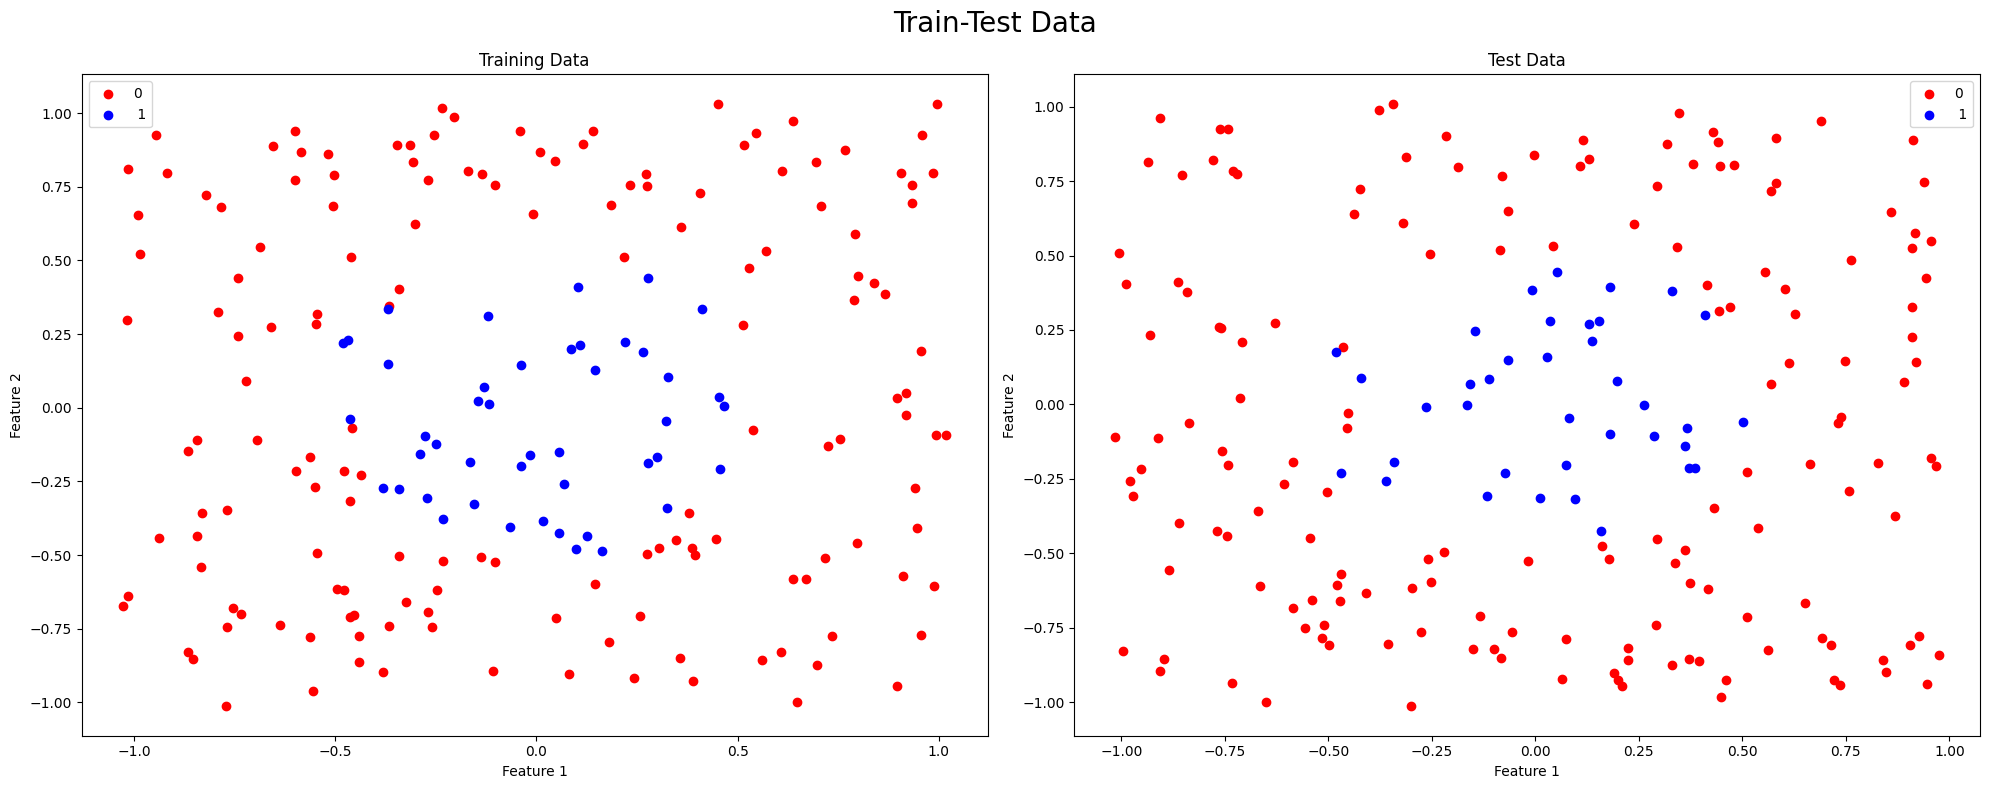

In [469]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'circle-no_embedding')

In [470]:
radial_distance_train = make_nonlinearity(x_train[:,0], x_train[:,1], lambda x, y: (x**2 + y**2))
radial_distance_test = make_nonlinearity(x_test[:,0], x_test[:,1], lambda x, y: (x**2 + y**2))

In [471]:
x_train_augmented = np.c_[x_train, radial_distance_train]
x_test_augmented = np.c_[x_test, radial_distance_test]

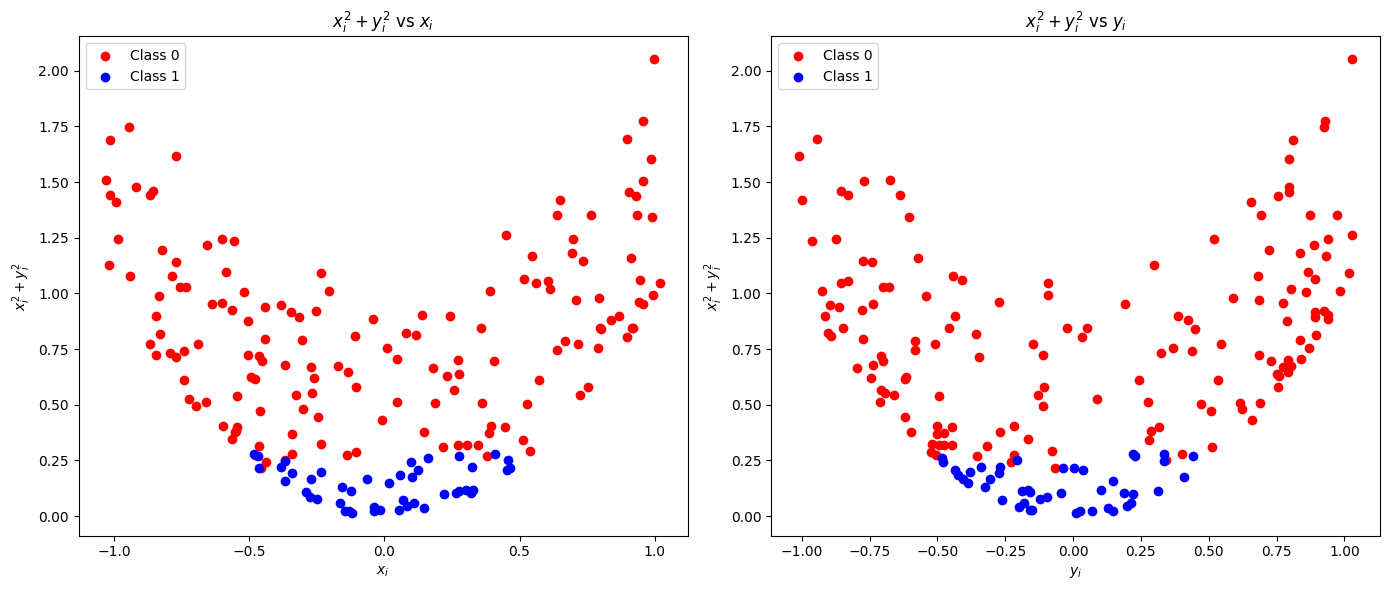

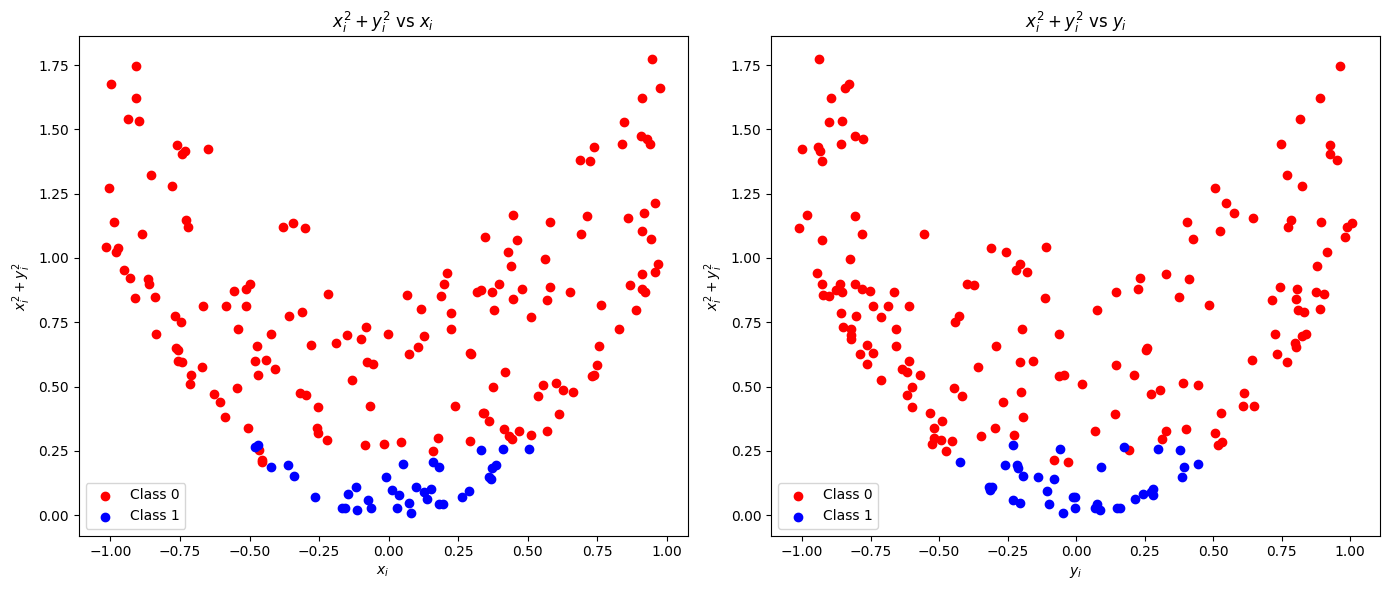

In [474]:
# plt.scatter(x_train_augmented[:, 0], x_train_augmented[:, 2], c=y_train.flatten())
plot_3d(x_train_augmented, y_train, 'x_{i}^2 + y_i^2', savefig=True, name='circle-embedding')
plot_3d(x_test_augmented,y_test,  'x_{i}^2 + y_i^2')

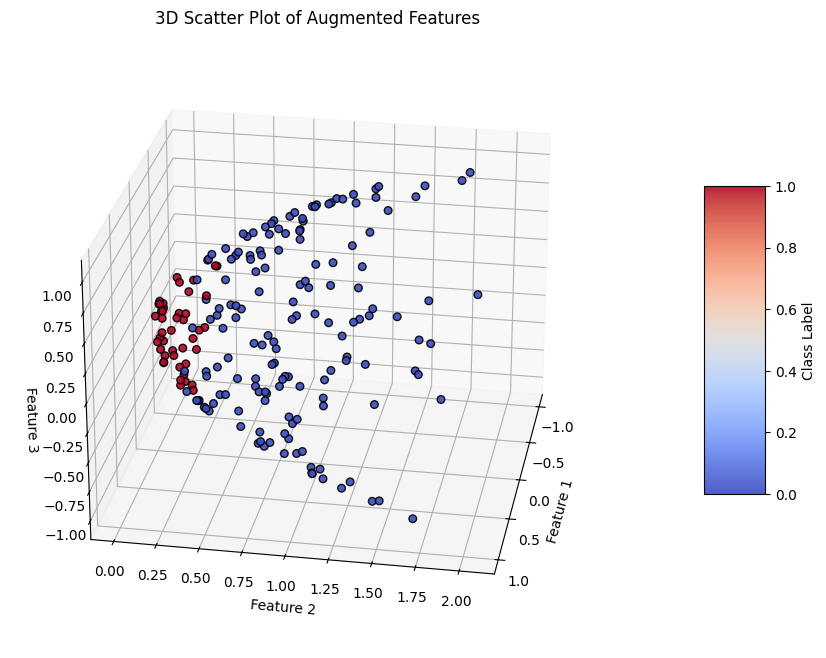

In [154]:
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using feature_1, feature_2, feature_3 and coloring by y_train
scatter = ax.scatter(feature_1, feature_3, feature_2, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Augmented Features')
ax.view_init(elev=25, azim=10, vertical_axis='z')

# Adding a color bar to interpret the colors
fig.colorbar(scatter, shrink=0.5, aspect=5, label='Class Label')

In [479]:
dim_in, dim_out = 3, 2
hidden_neuron_list = [1]
activation_list = ['ReLU', 'Sigmoid']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 3, Output Dim: 1, Parameters: 4
Layer 2: ReLU
Layer 3: Linear - A Dim: 1, Output Dim: 2, Parameters: 4
Layer 4: Sigmoid
Total Parameters: 8
None


In [480]:
circle_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=750)

Epoch: 0, Train Loss: 0.24904960897632966, Train Accuracy: 0.8392857142857143, Test Loss: 0.24884537644937998, Test Accuracy: 0.815
Epoch: 1, Train Loss: 0.24811987007627923, Train Accuracy: 0.8392857142857143, Test Loss: 0.24776219534319388, Test Accuracy: 0.825
Epoch: 2, Train Loss: 0.2474790650753612, Train Accuracy: 0.8258928571428571, Test Loss: 0.24669706613187425, Test Accuracy: 0.825
Epoch: 3, Train Loss: 0.24625870235005548, Train Accuracy: 0.8392857142857143, Test Loss: 0.2457207515259126, Test Accuracy: 0.825
Epoch: 4, Train Loss: 0.24535614243732548, Train Accuracy: 0.8303571428571429, Test Loss: 0.2446977681512018, Test Accuracy: 0.815
Epoch: 5, Train Loss: 0.2448025700454878, Train Accuracy: 0.7991071428571429, Test Loss: 0.24366389441806433, Test Accuracy: 0.825
Epoch: 6, Train Loss: 0.24378559393597282, Train Accuracy: 0.7901785714285714, Test Loss: 0.24266205710083852, Test Accuracy: 0.82
Epoch: 7, Train Loss: 0.2422375225609374, Train Accuracy: 0.8035714285714286, Tes

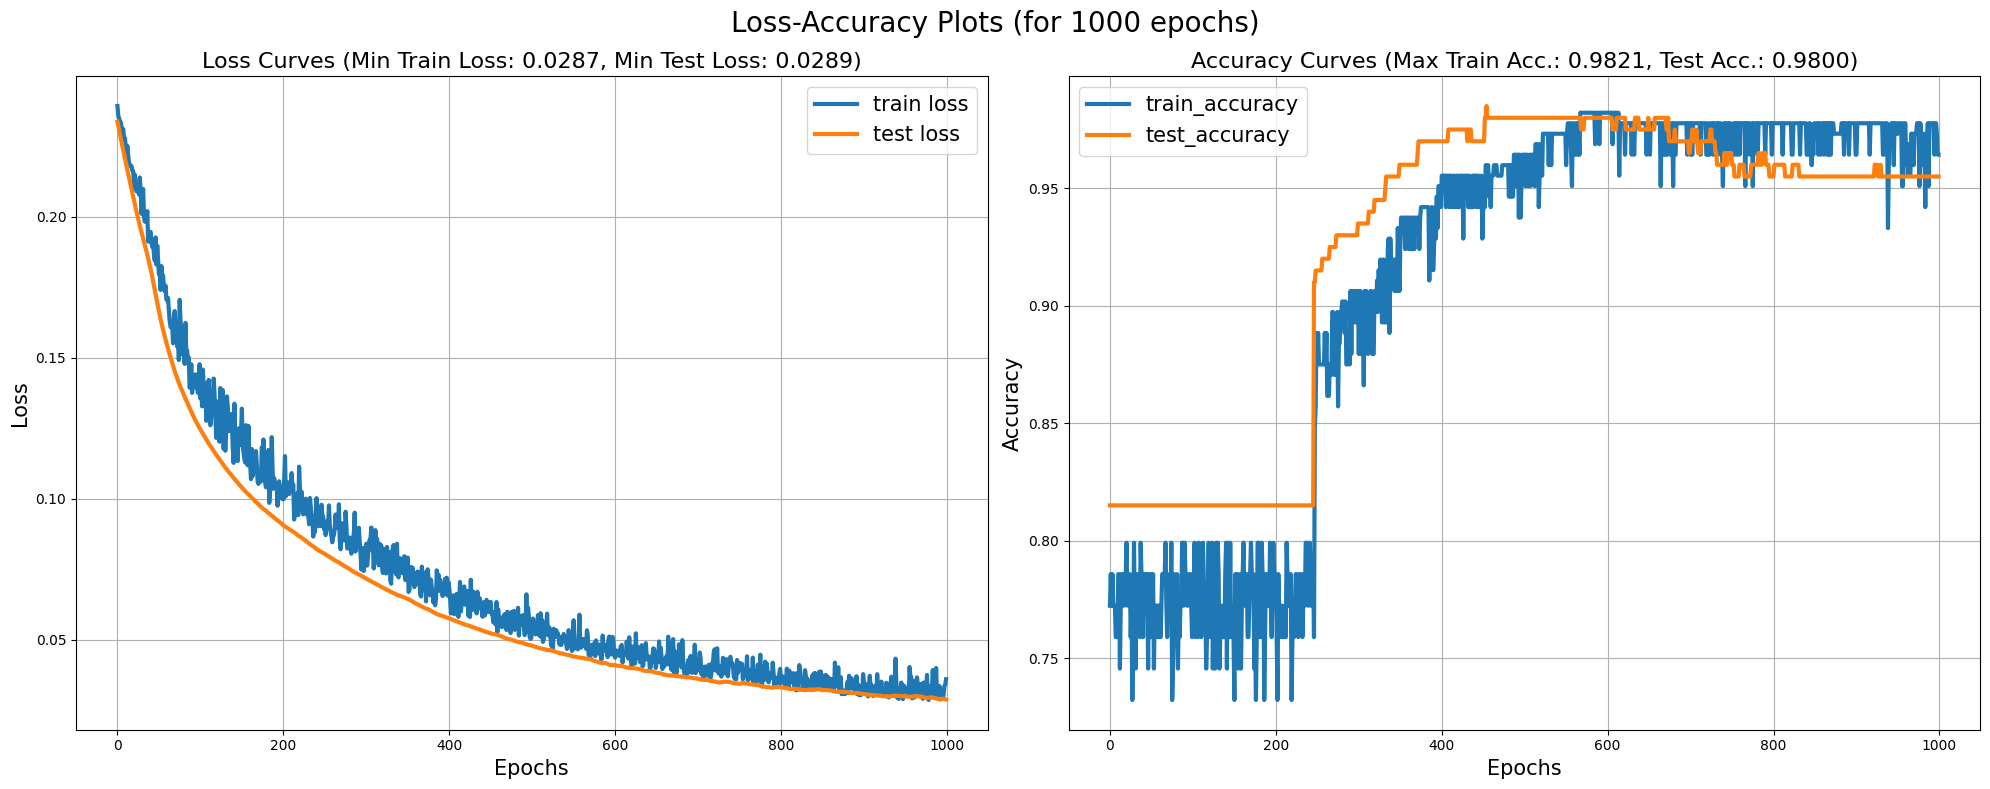

In [157]:
epochs = len(circle_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(circle_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(circle_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.tight_layout()

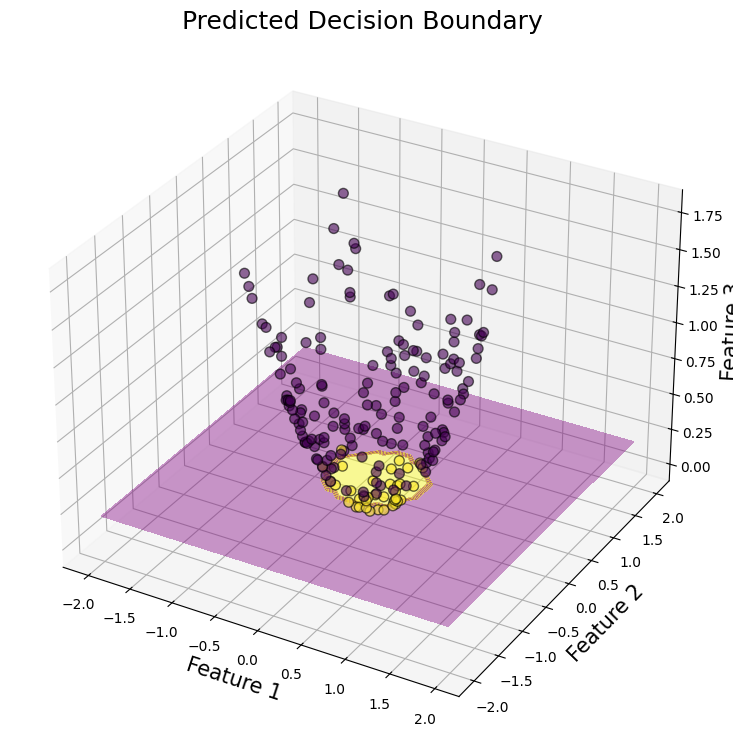

In [490]:
non_linearities =[(lambda x, y: (x**2 + y**2))]
decision_boundary_plot(x_test_augmented, y_test, non_linearities, model=mlp,i=2, savefig=True,levels=10, name='cicular-embedding-db')

# XOR

In [187]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'XOR',nTrain=200, nTest=200)

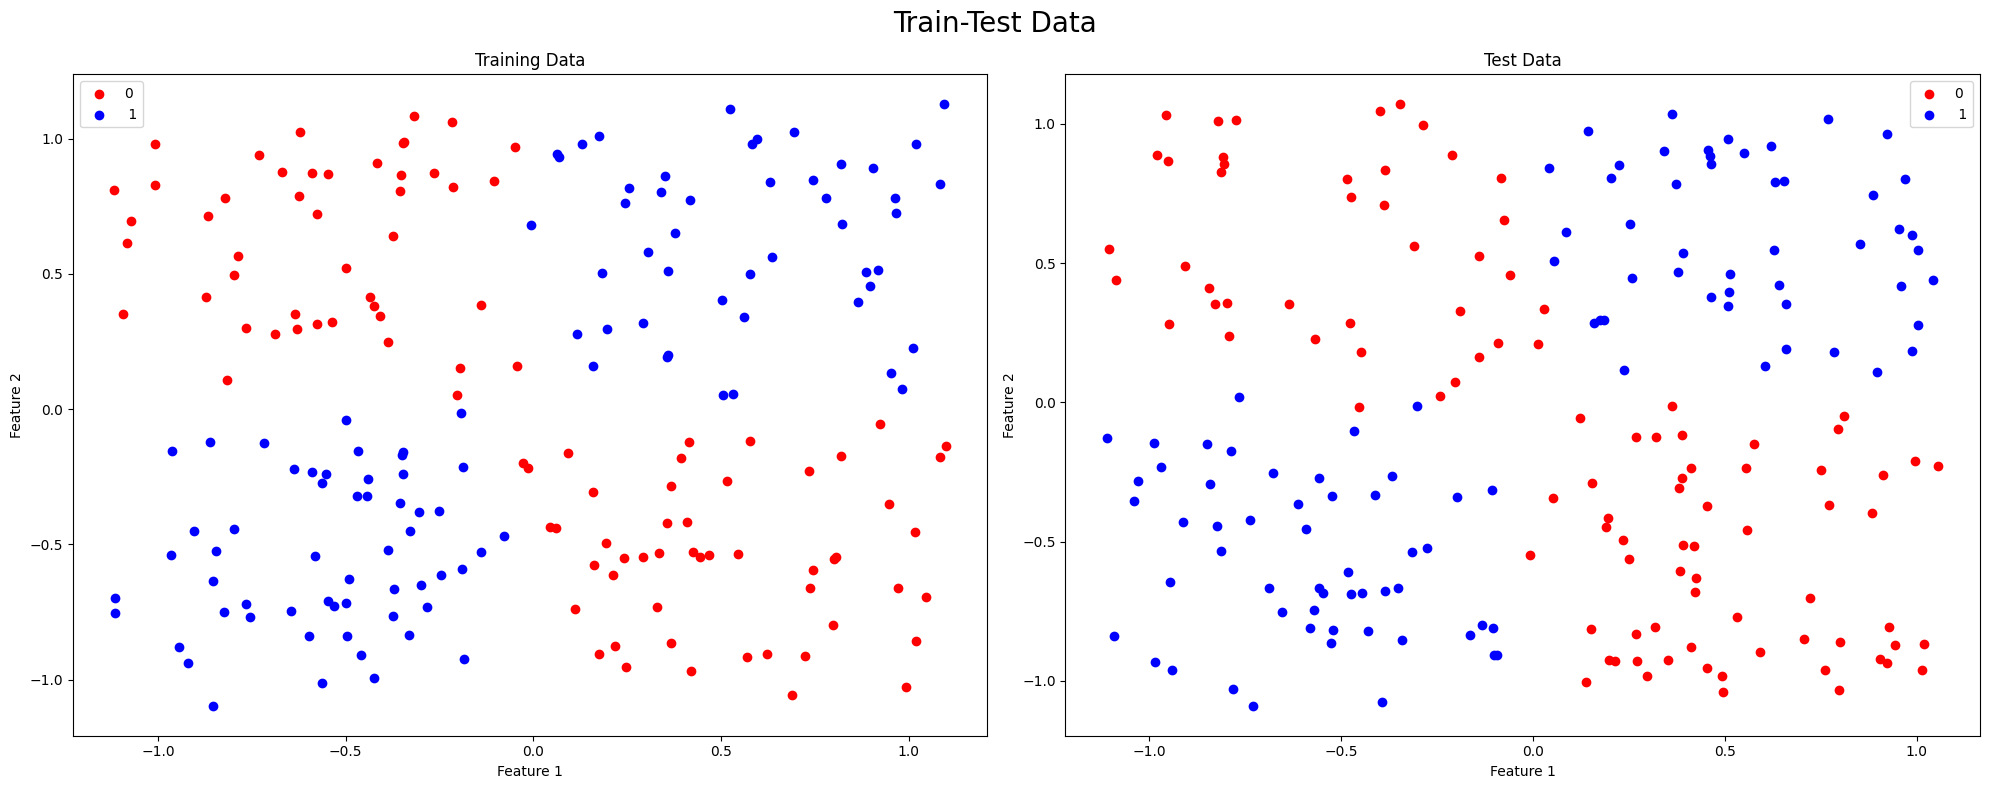

In [188]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'XOR')

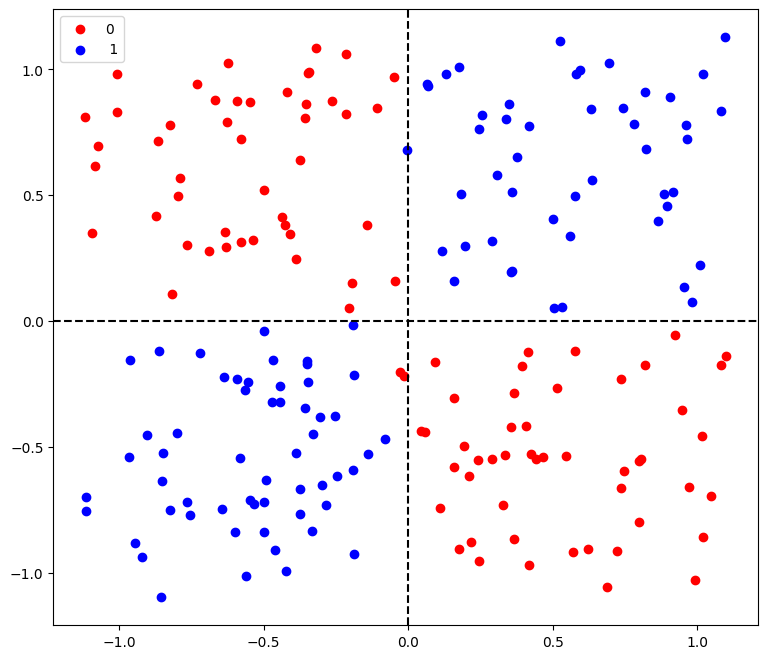

In [189]:
# Now, separate x_train data points
x_train_0 = x_train[y_train.flatten() == 0]
x_train_1 = x_train[y_train.flatten() == 1]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(x_train_0[:, 0], x_train_0[:, 1], c='red', label='0')
plt.scatter(x_train_1[:, 0], x_train_1[:, 1], c='blue', label=' 1')
plt.legend()
# vertical line at 0
plt.axvline(x=0, color='k', linestyle='--')
# horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--')

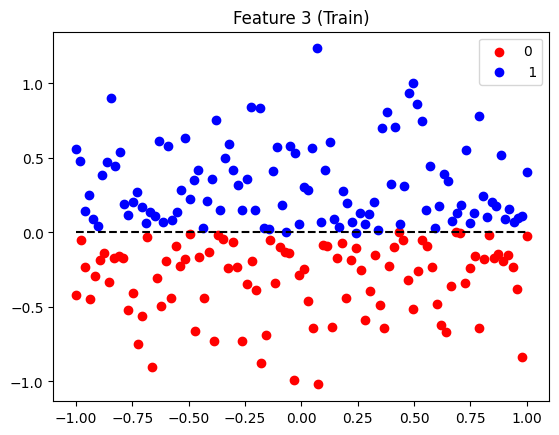

In [190]:
feature_3 = x_train[:, 0] * x_train[:, 1]
feature_3_0 = feature_3[y_train.flatten() == 0]
feature_3_1 = feature_3[y_train.flatten() == 1]

plt.scatter(np.linspace(-1, 1, num=len(feature_3_0))
, feature_3_0, c='red', label='0')

plt.scatter(np.linspace(-1, 1, num=len(feature_3_1))
,feature_3_1, c='blue', label=' 1')
plt.hlines(y=0, xmin=-1, xmax=1, color='k', linestyle='--')
plt.title('Feature 3 (Train)')
plt.legend()

In [191]:
radial_distance_train = make_nonlinearity(x_train[:,0], x_train[:,1], lambda x, y: (x*y))
radial_distance_test = make_nonlinearity(x_test[:,0], x_test[:,1], lambda x, y: (x*y))

In [192]:
x_train_augmented = np.c_[x_train, radial_distance_train]
x_test_augmented = np.c_[x_test, radial_distance_test]

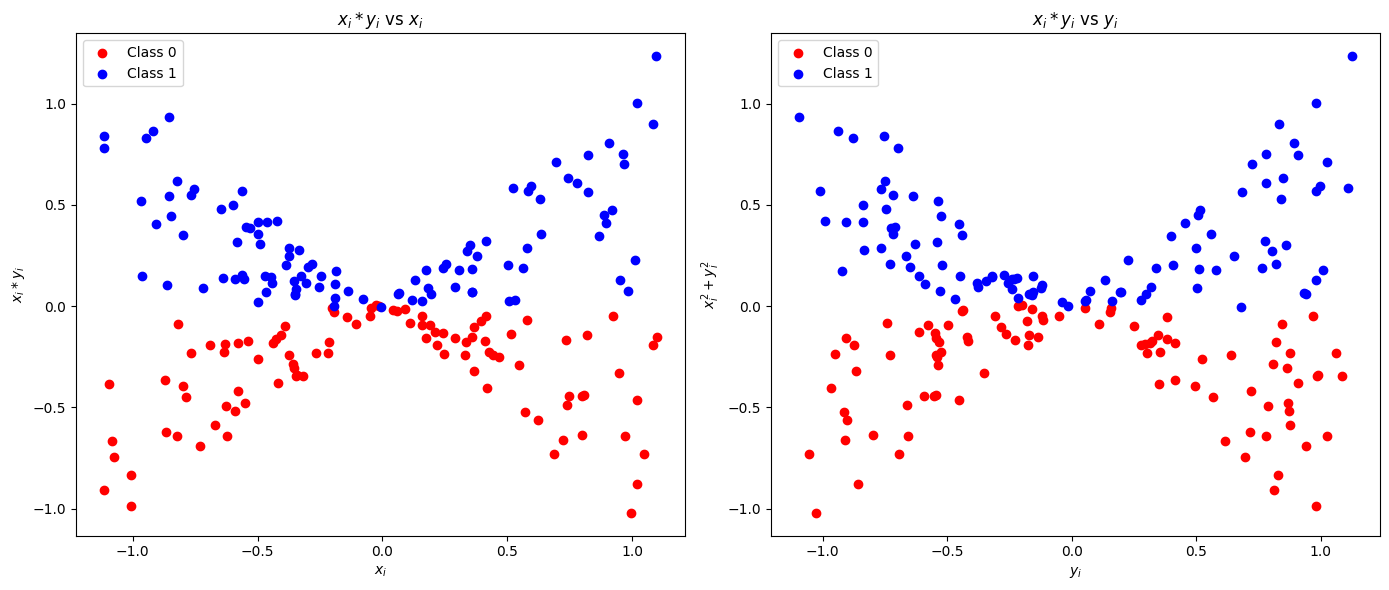

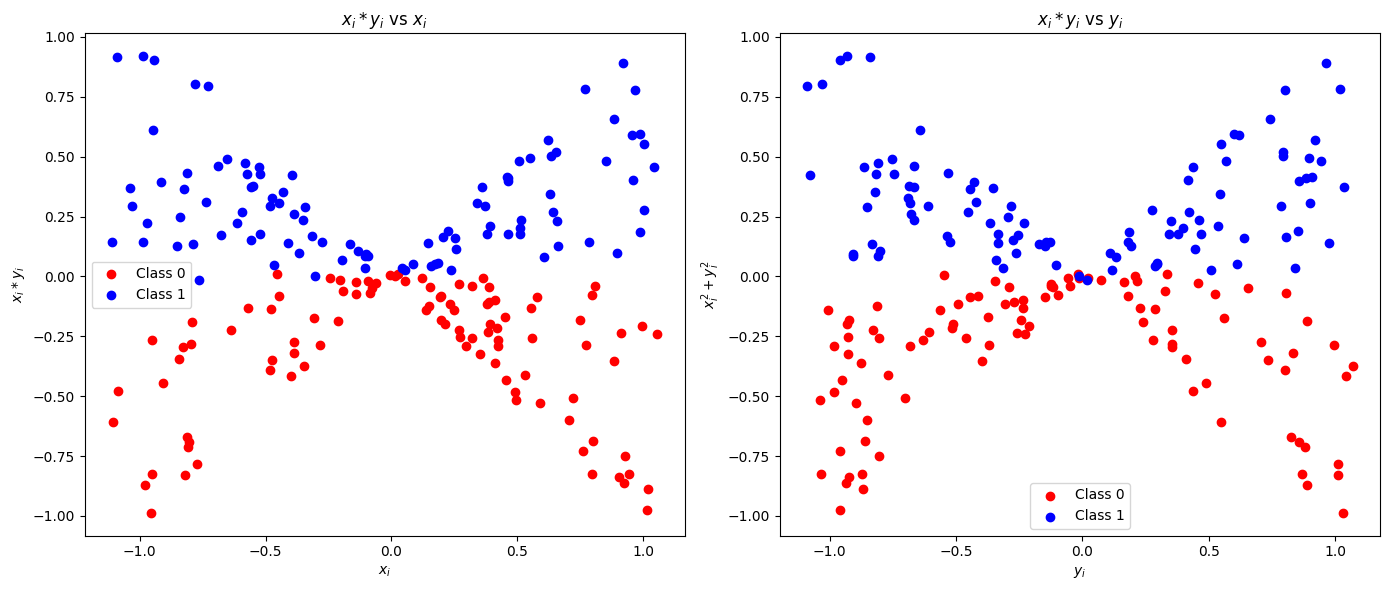

In [194]:
# plt.scatter(x_train_augmented[:, 0], x_train_augmented[:, 2], c=y_train.flatten())
plot_3d(x_train_augmented, y_train, 'x_{i} * y_i')
plot_3d(x_test_augmented,y_test,  'x_{i} * y_i')

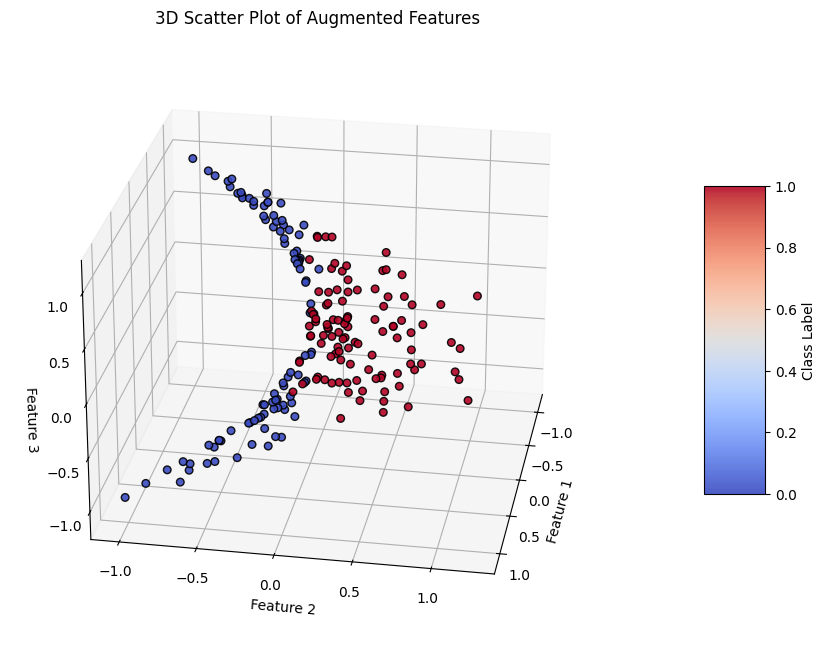

In [195]:
feature_1 = x_train_augmented[:, 0]
feature_2 = x_train_augmented[:, 1]
feature_3 = x_train_augmented[:, 2]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using feature_1, feature_2, feature_3 and coloring by y_train
scatter = ax.scatter(feature_1, feature_3, feature_2, c=y_train, cmap='coolwarm', edgecolors='k', s=30, alpha=0.9, marker='o')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Augmented Features')
ax.view_init(elev=25, azim=10, vertical_axis='z')

# Adding a color bar to interpret the colors
fig.colorbar(scatter, shrink=0.5, aspect=5, label='Class Label')

In [196]:
dim_in, dim_out = 3, 2
hidden_neuron_list = [1]
activation_list = ['ReLU', 'Sigmoid']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 3, Output Dim: 1, Parameters: 4
Layer 2: ReLU
Layer 3: Linear - A Dim: 1, Output Dim: 2, Parameters: 4
Layer 4: Sigmoid
Total Parameters: 8
None


In [197]:
xor_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=1000)

Epoch: 0, Train Loss: 0.2504903374710828, Train Accuracy: 0.42857142857142855, Test Loss: 0.2486060241264786, Test Accuracy: 0.485
Epoch: 1, Train Loss: 0.2500525780729384, Train Accuracy: 0.4419642857142857, Test Loss: 0.24821472713908097, Test Accuracy: 0.49
Epoch: 2, Train Loss: 0.24888286202676022, Train Accuracy: 0.48214285714285715, Test Loss: 0.2478465204002338, Test Accuracy: 0.5
Epoch: 3, Train Loss: 0.24947273168831435, Train Accuracy: 0.48214285714285715, Test Loss: 0.2474910030956644, Test Accuracy: 0.51
Epoch: 4, Train Loss: 0.24855107562149215, Train Accuracy: 0.49107142857142855, Test Loss: 0.2471394622828302, Test Accuracy: 0.525
Epoch: 5, Train Loss: 0.24829025249394315, Train Accuracy: 0.5044642857142857, Test Loss: 0.2468021609193081, Test Accuracy: 0.535
Epoch: 6, Train Loss: 0.24703984813253227, Train Accuracy: 0.5357142857142857, Test Loss: 0.24647218385952094, Test Accuracy: 0.54
Epoch: 7, Train Loss: 0.2472759782812106, Train Accuracy: 0.5267857142857143, Test L

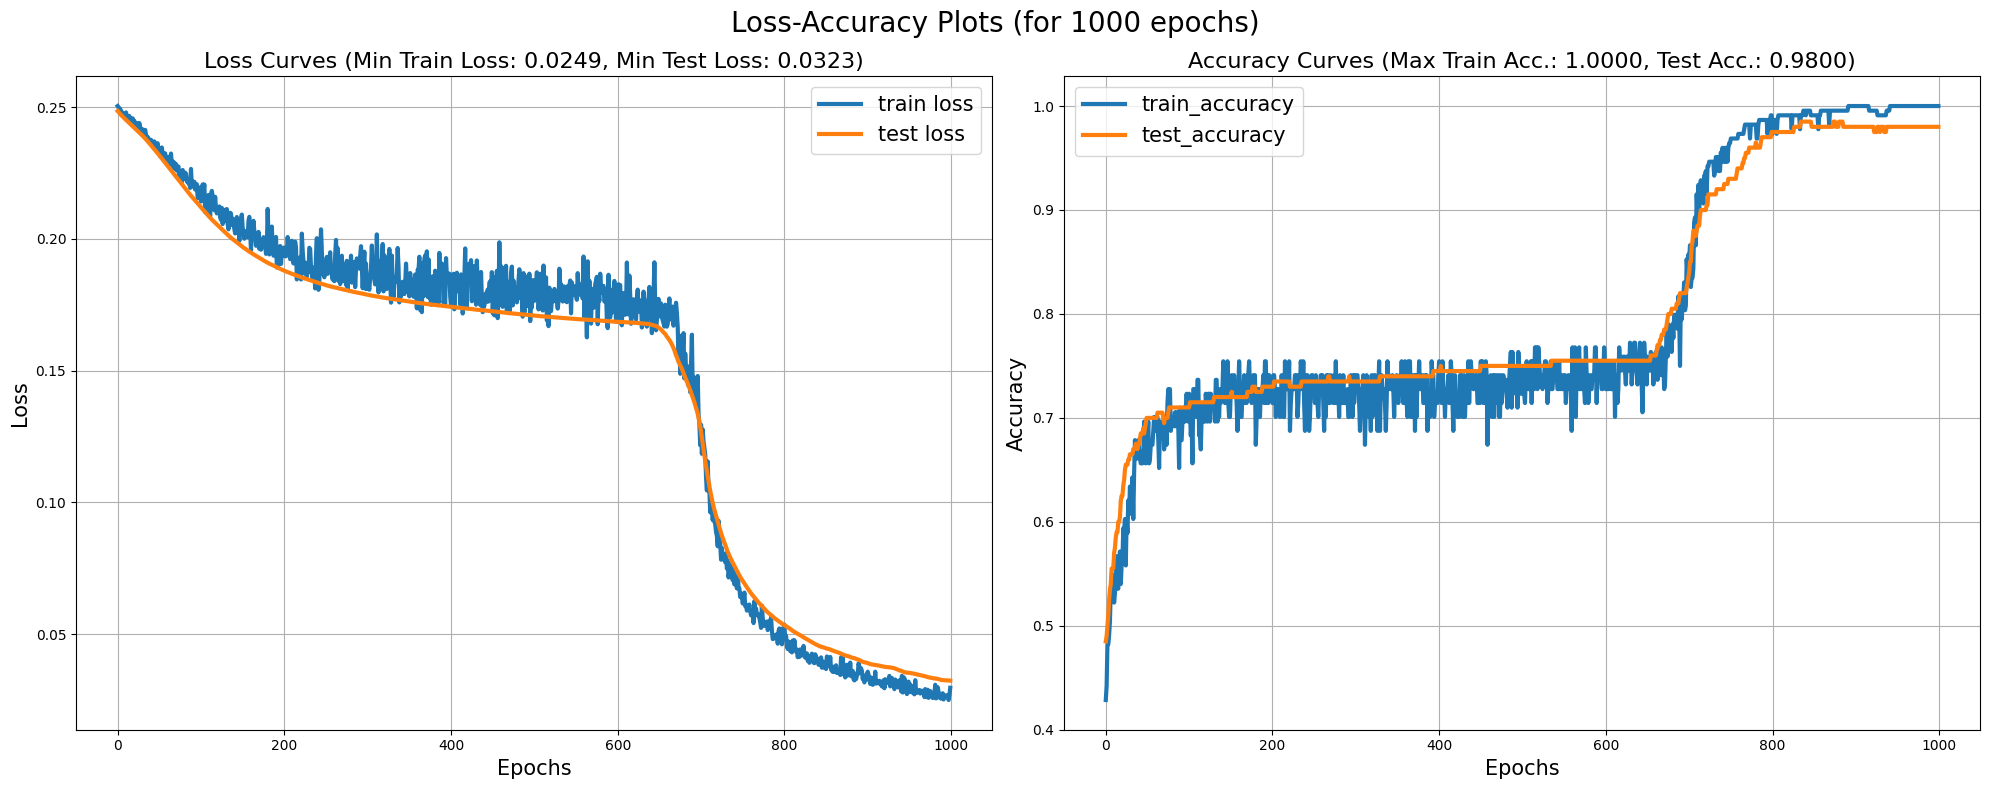

In [198]:
epochs = len(xor_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(xor_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(xor_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.savefig('xor-embedding-train-loss.png')
plt.tight_layout()

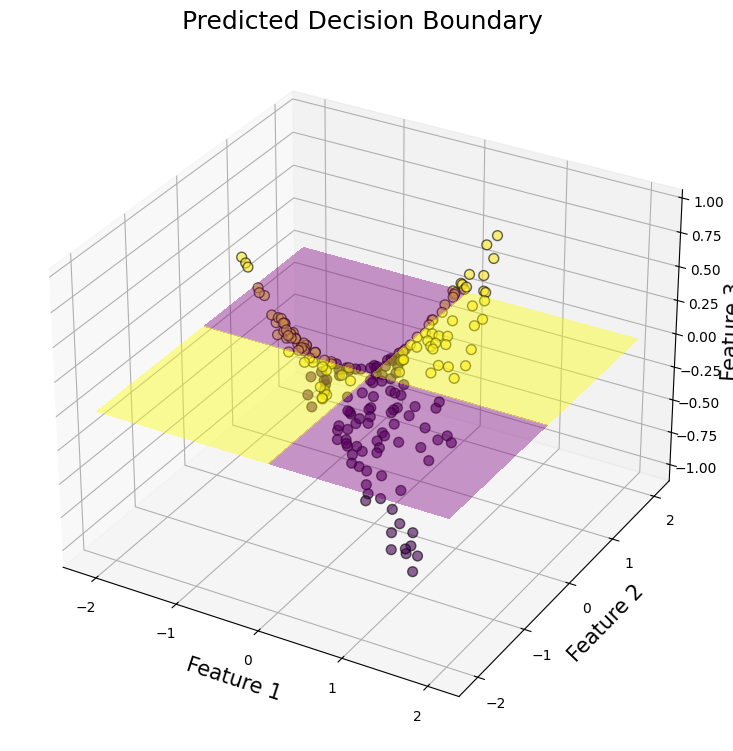

In [201]:
non_linearities =[(lambda x, y: (x*y))]
decision_boundary_plot(x_test_augmented, y_test, non_linearities, model=mlp,i=2, savefig=True,levels=1, name='xor-embedding-db')

# Swiss Roll

In [535]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'swiss-roll',nTrain=200, nTest=200)

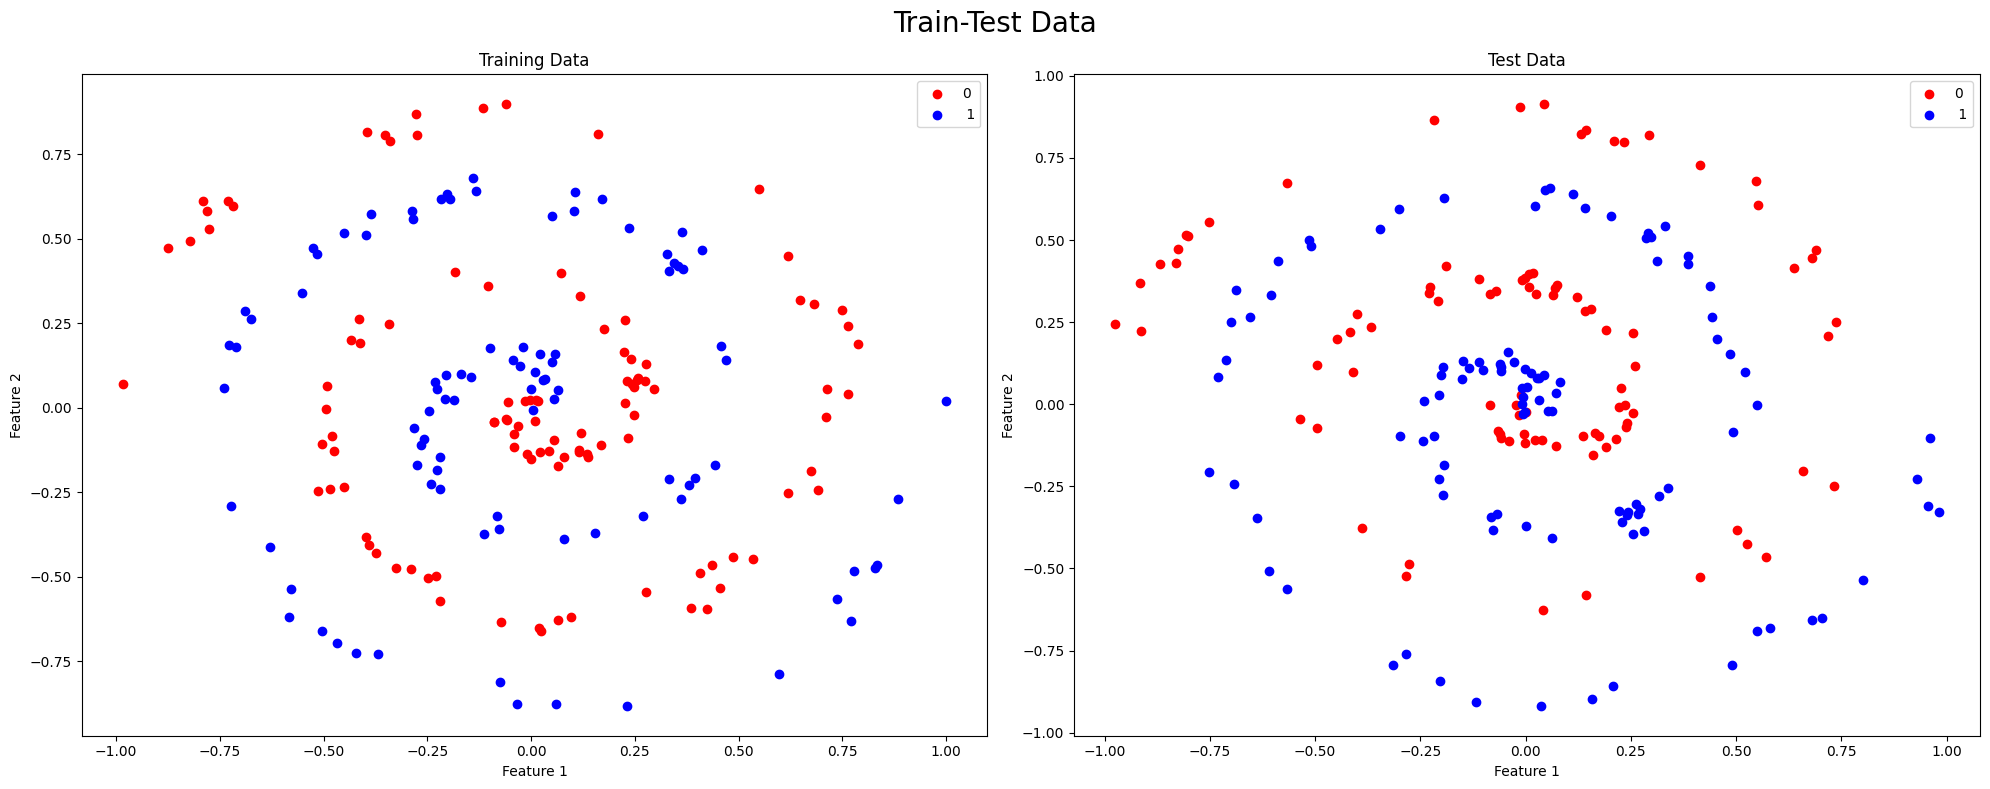

In [536]:
numpyNN.plot_train_test_data(x_train, y_train, x_test, y_test, 'swirl')

In [548]:
xsq_train = make_nonlinearity(x_train[:,0], x_train[:,1], lambda x, y: x**2 )
xsq_test = make_nonlinearity(x_test[:,0], x_test[:,1], lambda x, y: x**2 )
nonlin1 = lambda x, y: x**2

ysq_train = make_nonlinearity(x_train[:,0], x_train[:,1], lambda x, y: y**2 ) # np.sqrt(x**2 + y**2)
ysq_test = make_nonlinearity(x_test[:,0], x_test[:,1], lambda x, y: y**2 )
nonlin2 = lambda x, y: y**2

xy_train = make_nonlinearity(x_train[:,0], x_train[:,1], lambda x, y: x*y )
xy_test = make_nonlinearity(x_test[:,0], x_test[:,1], lambda x, y: x*y )
nonlin3 = lambda x, y: x*y

In [549]:
x_train_augmented = np.c_[x_train, xsq_train, ysq_train, xy_train] # , theta_train, ]
x_test_augmented = np.c_[x_test, xsq_test, ysq_test, xy_test] # , theta_test, ]

In [550]:
x_train_augmented.shape, x_test_augmented.shape

((200, 5), (200, 5))

In [573]:
dim_in, dim_out = 5, 2
hidden_neuron_list = [8,4]
activation_list = ['ReLU','ReLU','Tanh']
opt_init = 'xavier'
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(mlp, learning_rate=.001)
print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - A Dim: 5, Output Dim: 8, Parameters: 48
Layer 2: ReLU
Layer 3: Linear - A Dim: 8, Output Dim: 4, Parameters: 36
Layer 4: ReLU
Layer 5: Linear - A Dim: 4, Output Dim: 2, Parameters: 10
Layer 6: Tanh
Total Parameters: 94
None


In [567]:
spiral_embedded_logs = train_and_test_mlp(mlp, x_train_augmented, y_train, x_test_augmented, y_test, opt_loss, opt_optim, num_epoch=700)

Epoch: 0, Train Loss: 0.4657022379435454, Train Accuracy: 0.4330357142857143, Test Loss: 0.4523969409125382, Test Accuracy: 0.505
Epoch: 1, Train Loss: 0.4425752412034187, Train Accuracy: 0.49107142857142855, Test Loss: 0.4390024571324575, Test Accuracy: 0.52
Epoch: 2, Train Loss: 0.4422720120059997, Train Accuracy: 0.45089285714285715, Test Loss: 0.4261752059575685, Test Accuracy: 0.53
Epoch: 3, Train Loss: 0.4247793649472648, Train Accuracy: 0.4375, Test Loss: 0.4140644854673498, Test Accuracy: 0.53
Epoch: 4, Train Loss: 0.41985688090367373, Train Accuracy: 0.42857142857142855, Test Loss: 0.4028350896258031, Test Accuracy: 0.535
Epoch: 5, Train Loss: 0.4050910463037284, Train Accuracy: 0.4419642857142857, Test Loss: 0.39260159999097227, Test Accuracy: 0.535
Epoch: 6, Train Loss: 0.39271004723237335, Train Accuracy: 0.45535714285714285, Test Loss: 0.38312033779658533, Test Accuracy: 0.535
Epoch: 7, Train Loss: 0.38108775480292867, Train Accuracy: 0.46875, Test Loss: 0.3739128906296992

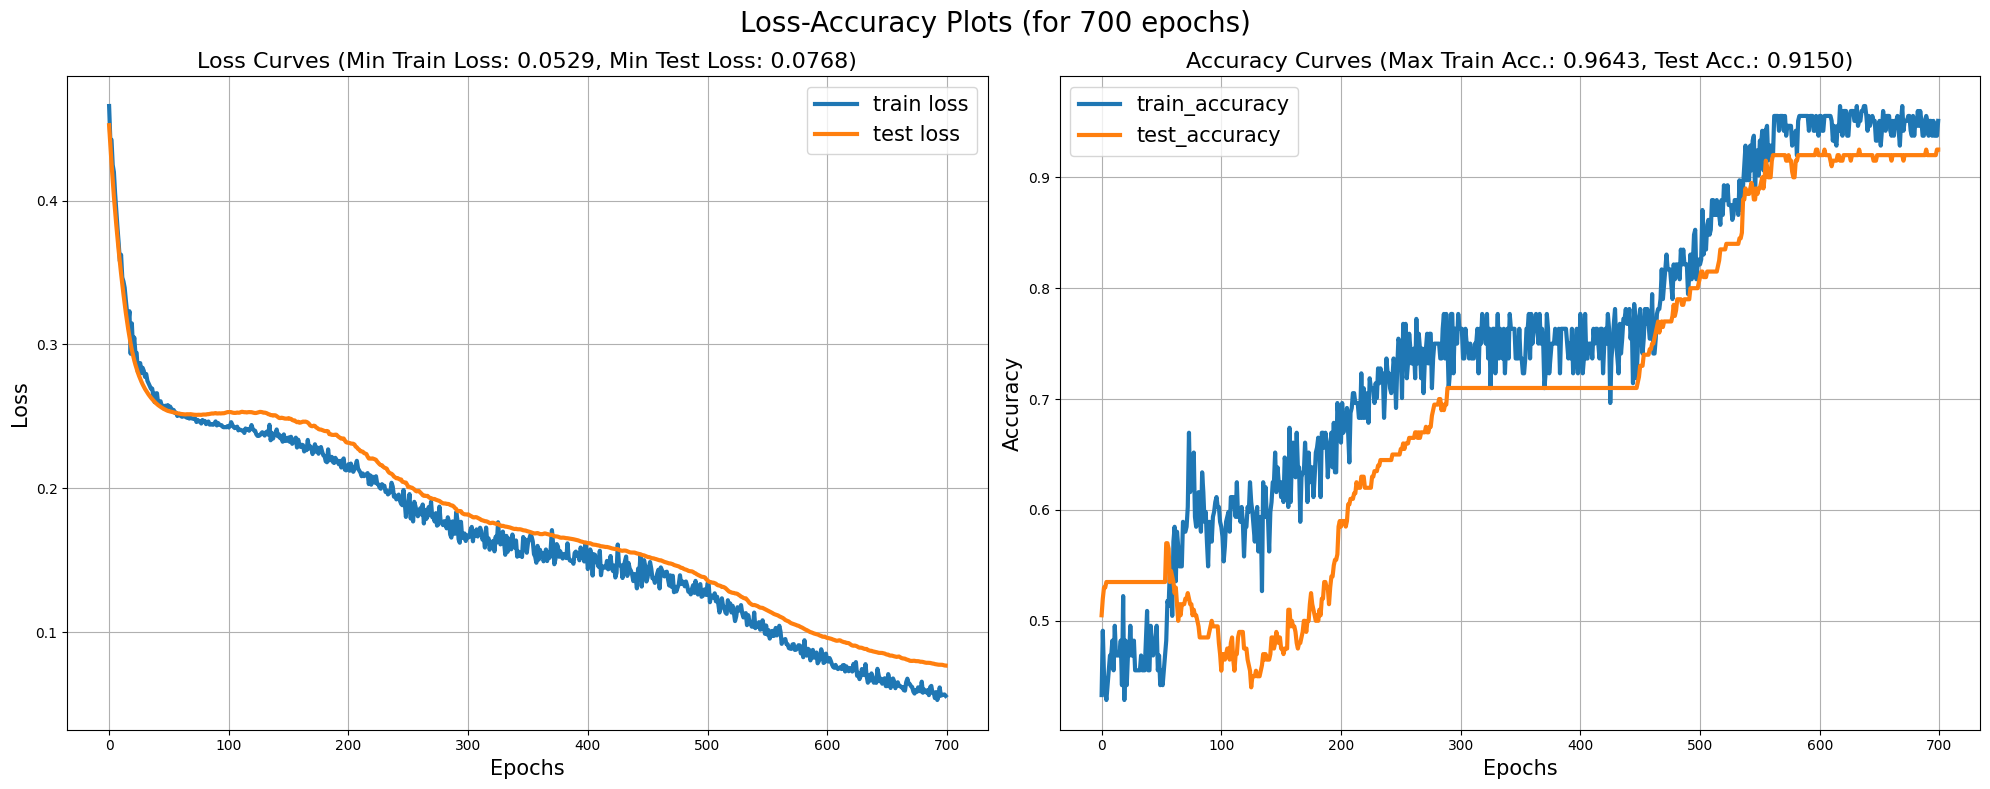

In [569]:
epochs = len(spiral_embedded_logs['train_loss'])
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
numpyNN.plot_loss(spiral_embedded_logs)
plt.subplot(1, 2, 2)
numpyNN.plot_accuracy(spiral_embedded_logs)
plt.suptitle(f'Loss-Accuracy Plots (for {epochs} epochs)', fontsize=20)
plt.tight_layout()

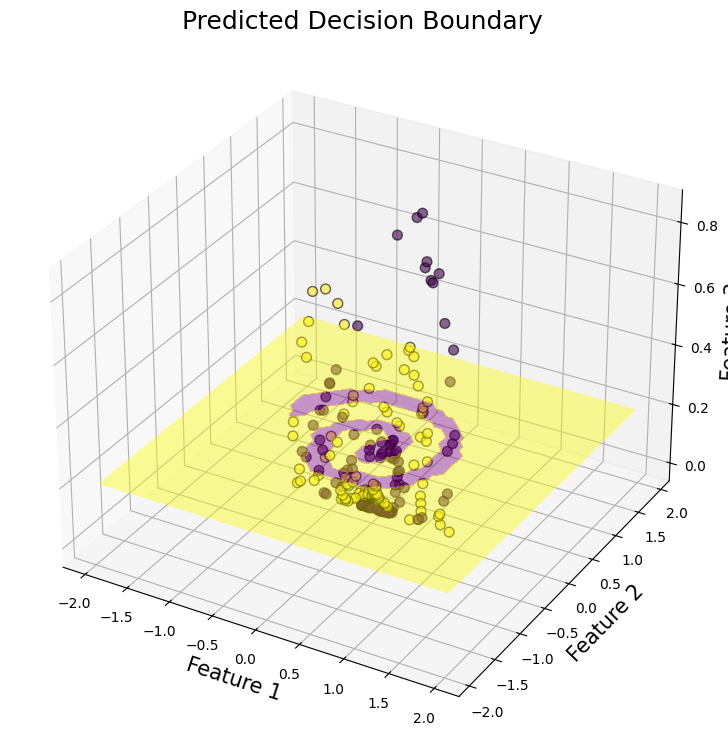

In [568]:
non_linearities =[nonlin1, nonlin2, nonlin3]
decision_boundary_plot(x_test_augmented, y_test, non_linearities, model=mlp,i=3, savefig=True,levels=1, name='spiral-embedding-db')